# Exploring DNN Fits

## Configuration

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [90]:
import os
import pickle
import re
from collections import defaultdict
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import itertools

from bgspy.learn import LearnedFunction, LearnedB
from bgspy.theory import bgs_segment, bgs_rec
from bgspy.plots import bhat_plot, loss_plot, loss_limits_plot, rate_loss_plot
from bgspy.plots import b_learn_diagnostic_plot, rate_plot, arch_loss_plot, rate_density_plot
from bgspy.plots import B_loss_plot, feature_loss_plot, feature_loss_plots, theory_loss_plot, rf_plot
from bgspy.nb_utils import load_learnedfuncs_in_dir
from bgspy.utils import signif, arg_nearest

#os.environ["CUDA_VISIBLE_DEVICES"]="1,1"

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 300
plt.style.use('./buffalo.mplstyle')

In [6]:
info = np.load('../exp-chunks/info.npz')

In [89]:
info['w'], info['t']

(array([1.e-07, 1.e-08, 1.e-09]),
 array([1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]))

In [8]:
from bgspy.genome import Genome
from bgspy.models import BGSModel

In [73]:
g = Genome('hg38', chroms='chr10', seqlens_file="../data/annotation/hg38_seqlens.tsv")
g.load_annot("../data/annotation/conserved_by_chrom/chr10.bed")
g.load_recmap("../data/annotation/hapmap/genetic_map_GRCh37_chr10.txt")


ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)


In [125]:
m = BGSModel(g, 
             w_grid=np.array((1e-7,1e-8,1e-9)),
             t_grid=np.array((0.01,0.02,1e-3,2e-3,1e-4,1e-5)))

In [86]:
pkl_b_file = '../data/bmaps/bgspy/B_chr10.pkl'

m.load_B(pkl_b_file)

In [126]:
m.calc_B(step=1_000, ncores=70, nchunks=70)

Genome divided into 70 chunks to be processed on 70 CPUs...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [05:42<00:00,  4.89s/it]


In [77]:
files = sorted([f for f in os.listdir('../exp-chunks/chr10/')], key=lambda x: int(x.split('_')[2]))
chr10_bs = [np.load(os.path.join('../exp-chunks/chr10/', b)) for b in files]

In [121]:
LearnedB.load_predictions(g, '../dnnb/')

IndexError: list assignment index out of range

In [122]:
debug

> /home/vsb/projects/bprime/bgspy/parallel.py(118)collate_unsorted()
    116                 extra_results += 1
    117                 continue
--> 118             Bs[chrom][i] = B
    119             B_pos[chrom][i] = self.chrom_pos_chunks[chrom][i]
    120         if extra_results:



ipdb>  u


> /home/vsb/projects/bprime/bgspy/learn.py(774)load_predictions()
    772             for i, file in zip(ids, files):
    773                 results[(chrom, i)] = np.load(join(chrom_pred_dir, file))
--> 774         Bs, B_pos = chunks.collate_unsorted(results)
    775         return BScores(Bs, B_pos, self.w, self.t, info['step'])
    776 



ipdb>  info


ipdb>  info['nchunks']


array(100)


ipdb>  exit


In [78]:
DATADIR = '../data/slim_sims/bgsmap/'
tree_files = [os.path.join(DATADIR, f) for f in os.listdir(DATADIR) if f.endswith('.tree')]
cached_bgsmap_file = '../data/bmaps/bgsmap_sims.pkl'
force=False
if force or not os.path.exists(cached_bgsmap_file):
    sims = defaultdict(list)

    for file in tqdm.tqdm(tree_files):
        params, pos, b = get_b(file, ('s', 'mu'))
        sims[params].append((pos, b))

    for key, res in sims.items():
        pos = list(map(operator.itemgetter(0), res))
        b = list(map(operator.itemgetter(1), res))
        sims[key] = np.stack(pos)[0, :], np.stack(b).T
    with open(cached_bgsmap_file, 'wb') as f:
        pickle.dump(sims, f)
else:
    with open(cached_bgsmap_file, 'rb') as f:
        sims = pickle.load(f)    

In [79]:
sims.keys()

dict_keys([(('s', 0.0002), ('mu', 1e-08)), (('s', 0.002), ('mu', 1e-08)), (('s', 0.02), ('mu', 1e-08)), (('s', 0.2), ('mu', 1e-08)), (('s', 2e-05), ('mu', 1e-08))])

In [80]:
m.Bs['chr10'].shape, chr10_bs[0].shape

((133799, 3, 5, 1), (3, 5, 1338))

In [81]:
info = np.load('../exp-chunks/info.npz')
info['w'], info['t']

(array([1.e-07, 1.e-08, 1.e-09]),
 array([1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]))

In [101]:
np.array((np.arange(10), np.arange(10))).T

array([[0, 0],
       [1, 1],
       [2, 2],
       [3, 3],
       [4, 4],
       [5, 5],
       [6, 6],
       [7, 7],
       [8, 8],
       [9, 9]])

In [133]:
def printer(x):
    print(x)
x = map(printer, range(10))

In [170]:
import json
from bgspy.samplers import ParamGrid
from bgspy.sim_utils import read_params

config = json.load(open('../slim_sims/bgs/bgsmap.json'))
params, types = read_params(config)

p = ParamGrid(params, nreps=10)

In [179]:
p.generate()

In [161]:
next(p)

{'rep': 0, 'N': 'grid', 'mu': 'grid', 's': 'type', 'h': 'type', 'chr': 'grid'}

0.01
1e-08


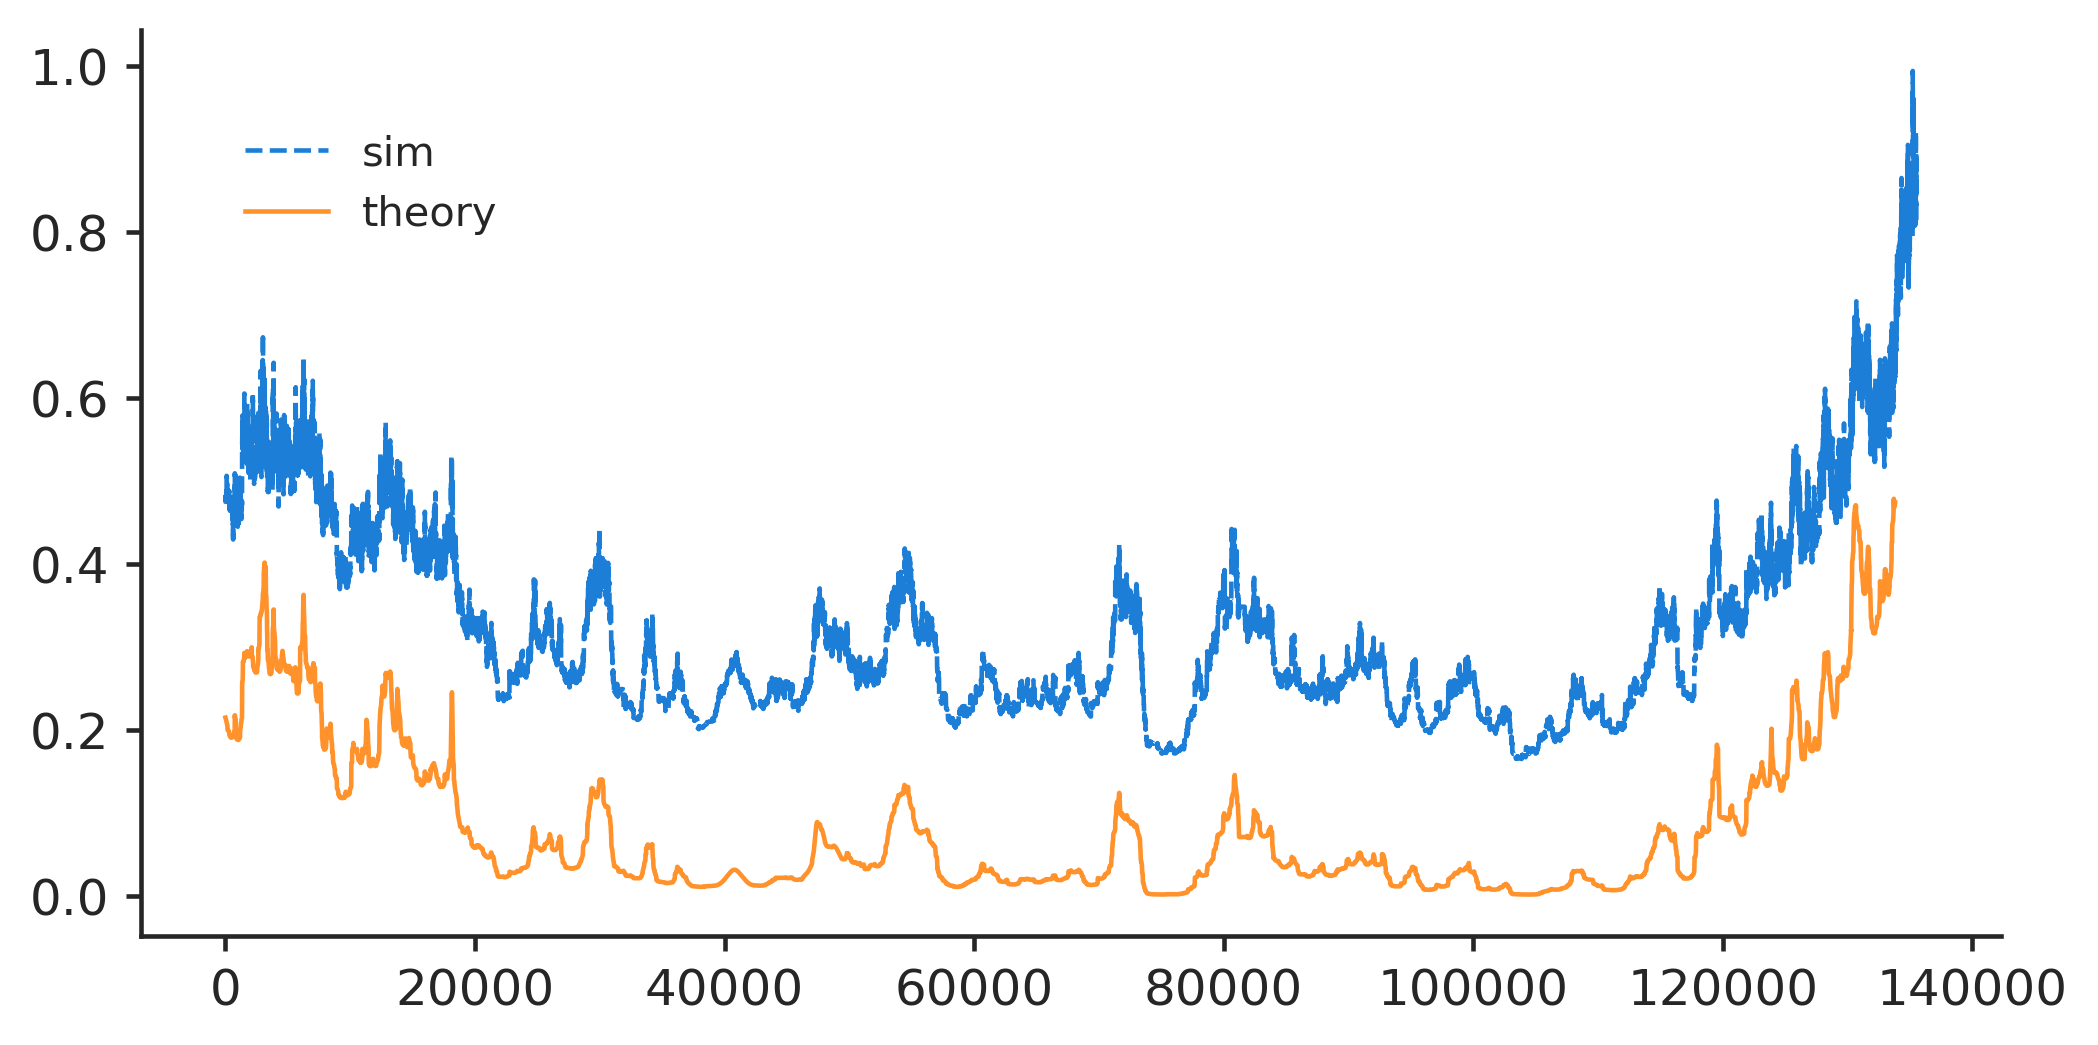

In [129]:
wi = 1

Bs = 10**(np.concatenate(chr10_bs, axis=2))

sels = range(len(info['t'])-1)

sels = [0]

for i in sels:
    s = info['t'][i]
    mu = info['w'][wi]
    res = sims.get((('s', 2*s), ('mu', mu)), None)

    pos_all, b_all = res
    bvar = b_all.var(axis=1)
    bmean = b_all.mean(axis=1)
    
    print(info['t'][i])#, m.t[i])
    print(info['w'][wi])#, m.w[wi])
    #line = plt.plot(np.arange(0, Bs.shape[2]), Bs[wi, i, :], label='dnnb')
    plt.plot(bmean, linestyle='dashed', label='sim')
    plt.plot(10**m.Bs['chr10'][:, arg_nearest(mu, m.w), arg_nearest(s, m.t), 0], label='theory')
plt.legend()

0.01
1e-08


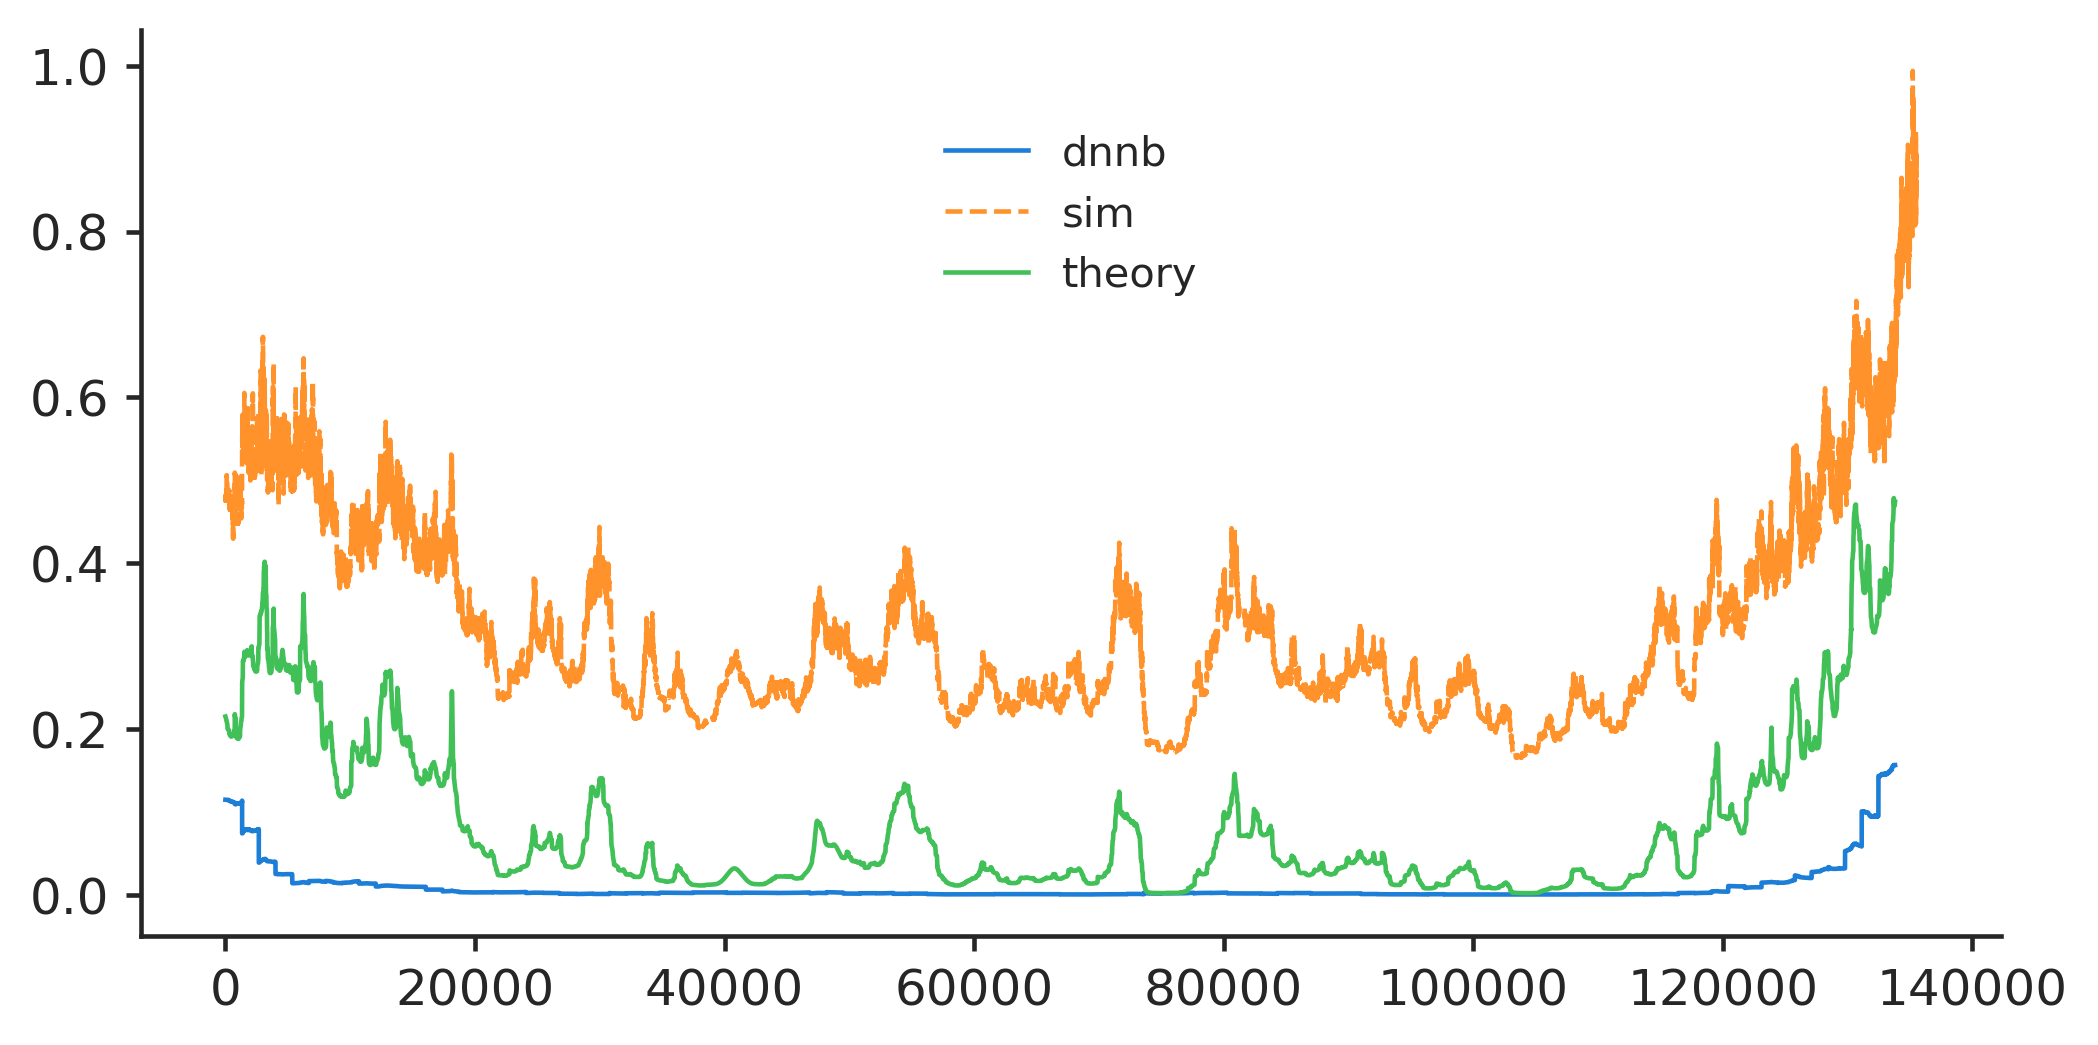

In [37]:
wi = 1

Bs = 10**(np.concatenate(chr10_bs, axis=2))

sels = range(len(info['t'])-1)

sels = [0]

for i in sels:
    s = info['t'][i]
    mu = info['w'][wi]
    res = sims.get((('s', 2*s), ('mu', mu)), None)

    pos_all, b_all = res
    bvar = b_all.var(axis=1)
    bmean = b_all.mean(axis=1)
    
    print(info['t'][i])#, m.t[i])
    print(info['w'][wi])#, m.w[wi])
    line = plt.plot(np.arange(0, Bs.shape[2]), Bs[wi, i, :], label='dnnb')
    plt.plot(bmean, linestyle='dashed', label='sim')
    plt.plot(10**m.Bs['chr10'][:, wi, i, 0], label='theory')
plt.legend()

0.001
1e-08


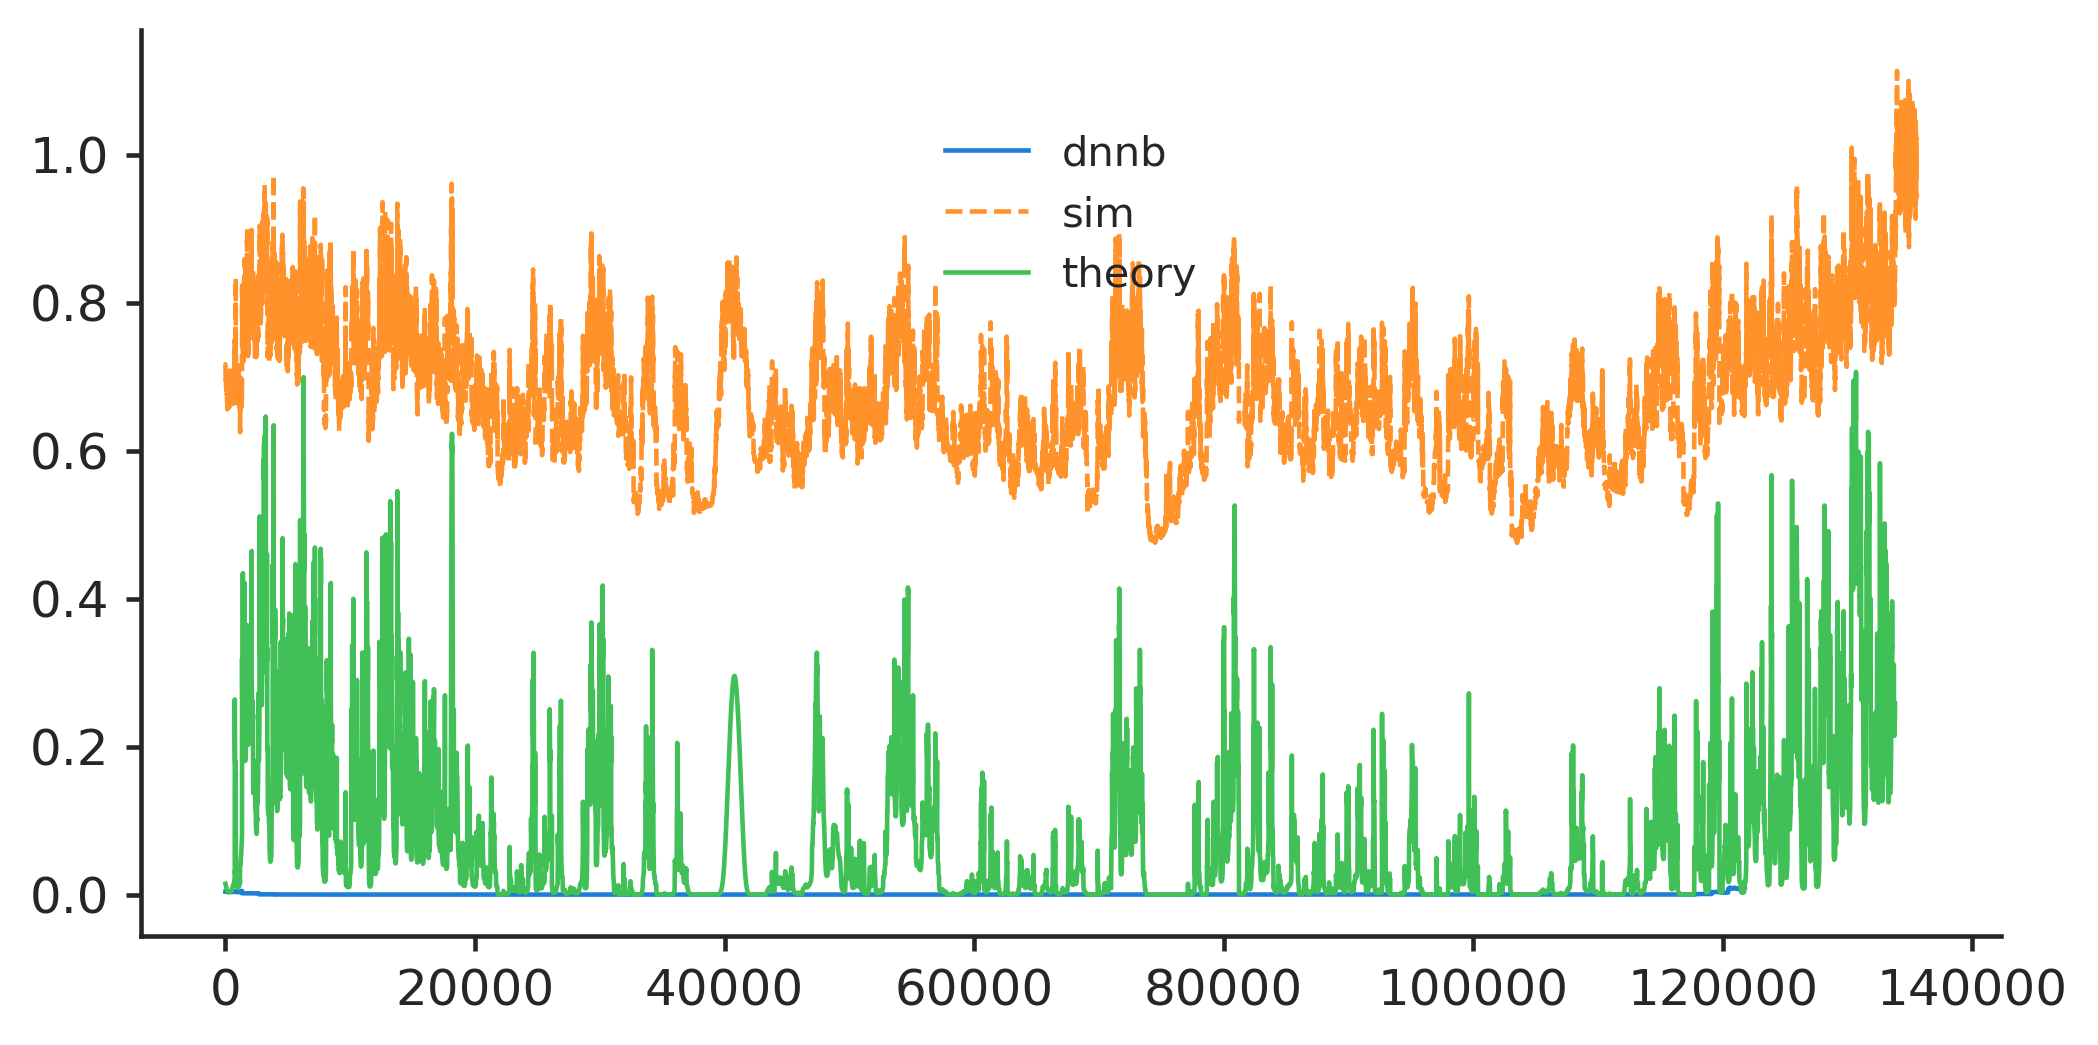

In [85]:
wi = 1

Bs = 10**(np.concatenate(chr10_bs, axis=2))

sels = range(len(info['t'])-1)

sels = [1]

for i in sels:
    s = info['t'][i]
    mu = info['w'][wi]
    res = sims.get((('s', 2*s), ('mu', mu)), None)

    pos_all, b_all = res
    bvar = b_all.var(axis=1)
    bmean = b_all.mean(axis=1)
    
    print(info['t'][i])#, m.t[i])
    print(info['w'][wi])#, m.w[wi])
    line = plt.plot(np.arange(0, Bs.shape[2]), Bs[wi, i, :], label='dnnb')
    plt.plot(bmean, linestyle='dashed', label='sim')
    plt.plot(10**m.Bs['chr10'][:, wi, i, 0], label='theory')
plt.legend()

0.001
1e-08


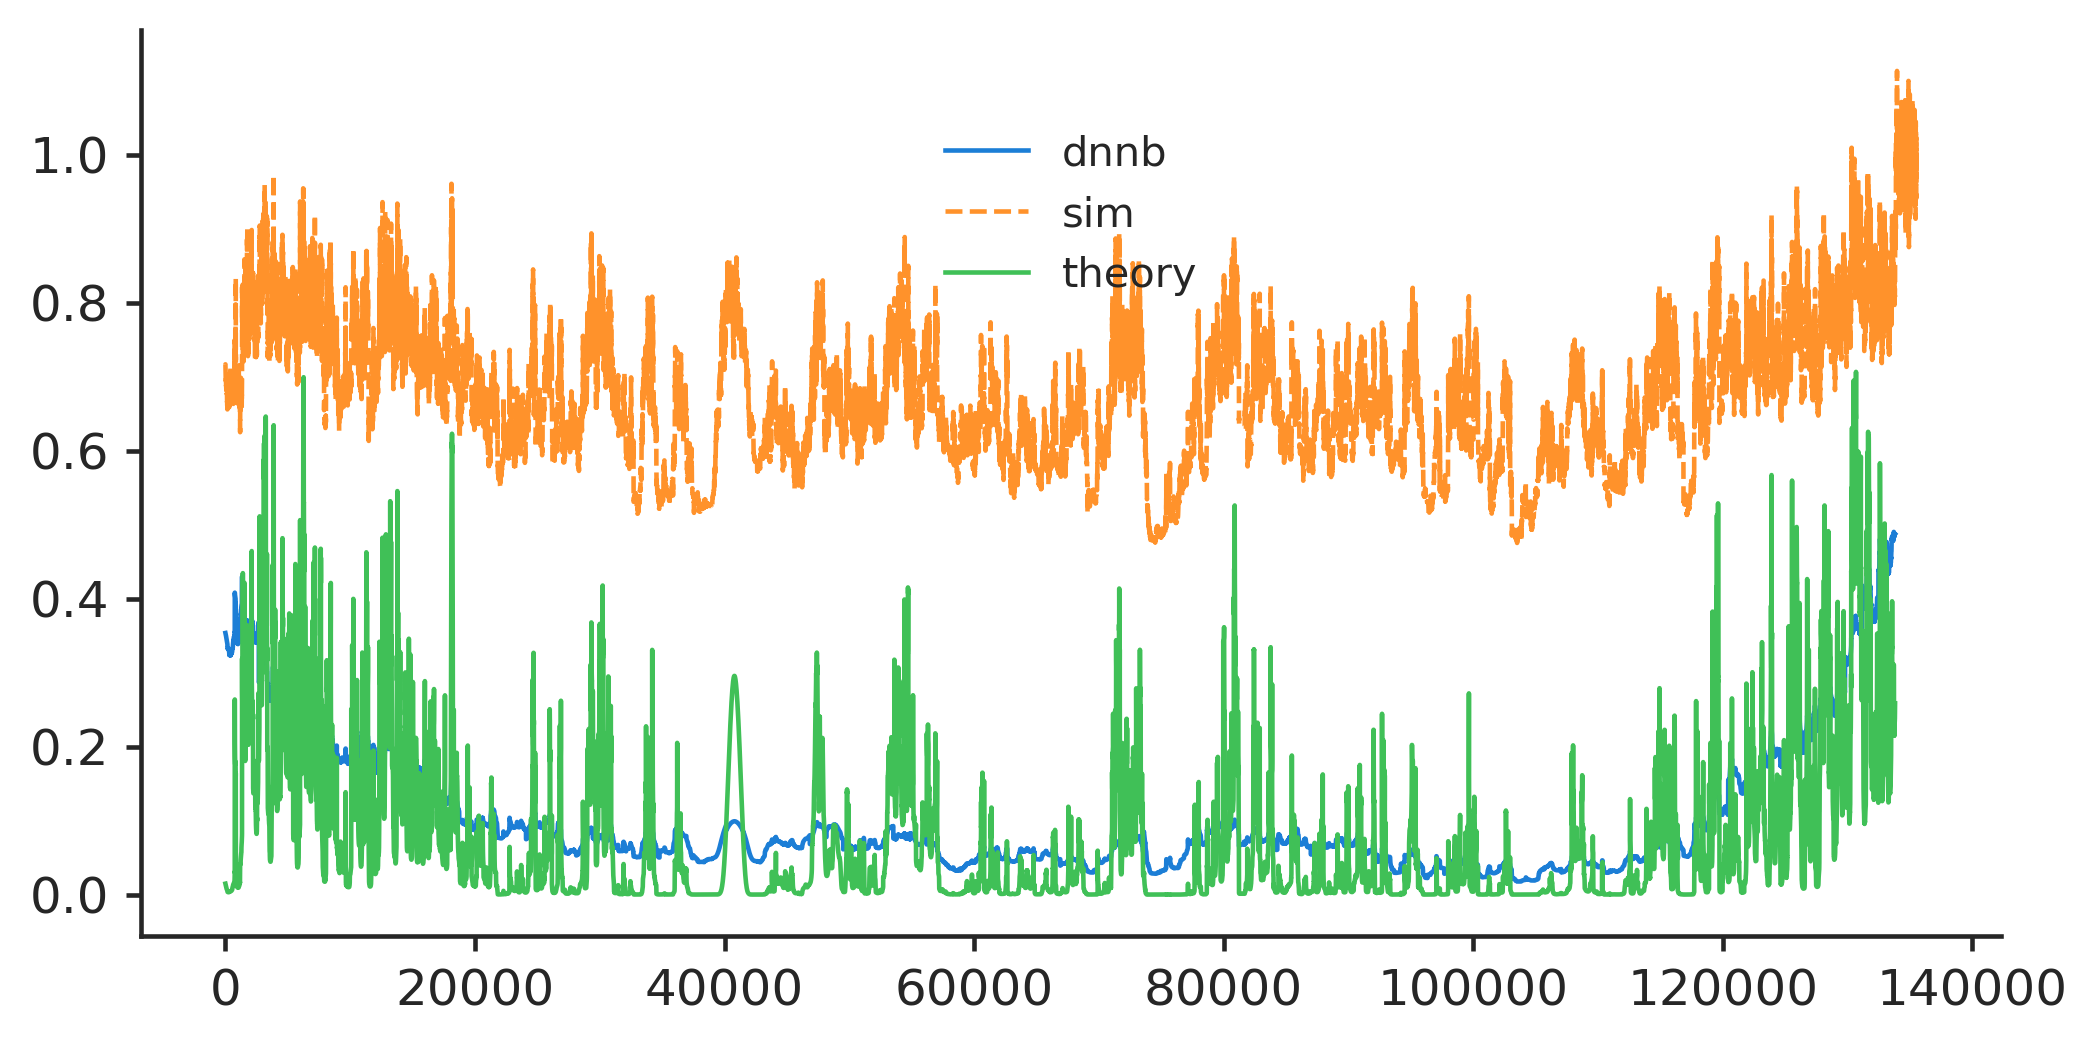

In [38]:
wi = 1

Bs = 10**(np.concatenate(chr10_bs, axis=2))

sels = range(len(info['t'])-1)

sels = [1]

for i in sels:
    s = info['t'][i]
    mu = info['w'][wi]
    res = sims.get((('s', 2*s), ('mu', mu)), None)

    pos_all, b_all = res
    bvar = b_all.var(axis=1)
    bmean = b_all.mean(axis=1)
    
    print(info['t'][i])#, m.t[i])
    print(info['w'][wi])#, m.w[wi])
    line = plt.plot(np.arange(0, Bs.shape[2]), Bs[wi, i, :], label='dnnb')
    plt.plot(bmean, linestyle='dashed', label='sim')
    plt.plot(10**m.Bs['chr10'][:, wi, i, 0], label='theory')
plt.legend()

0.0001
1e-08


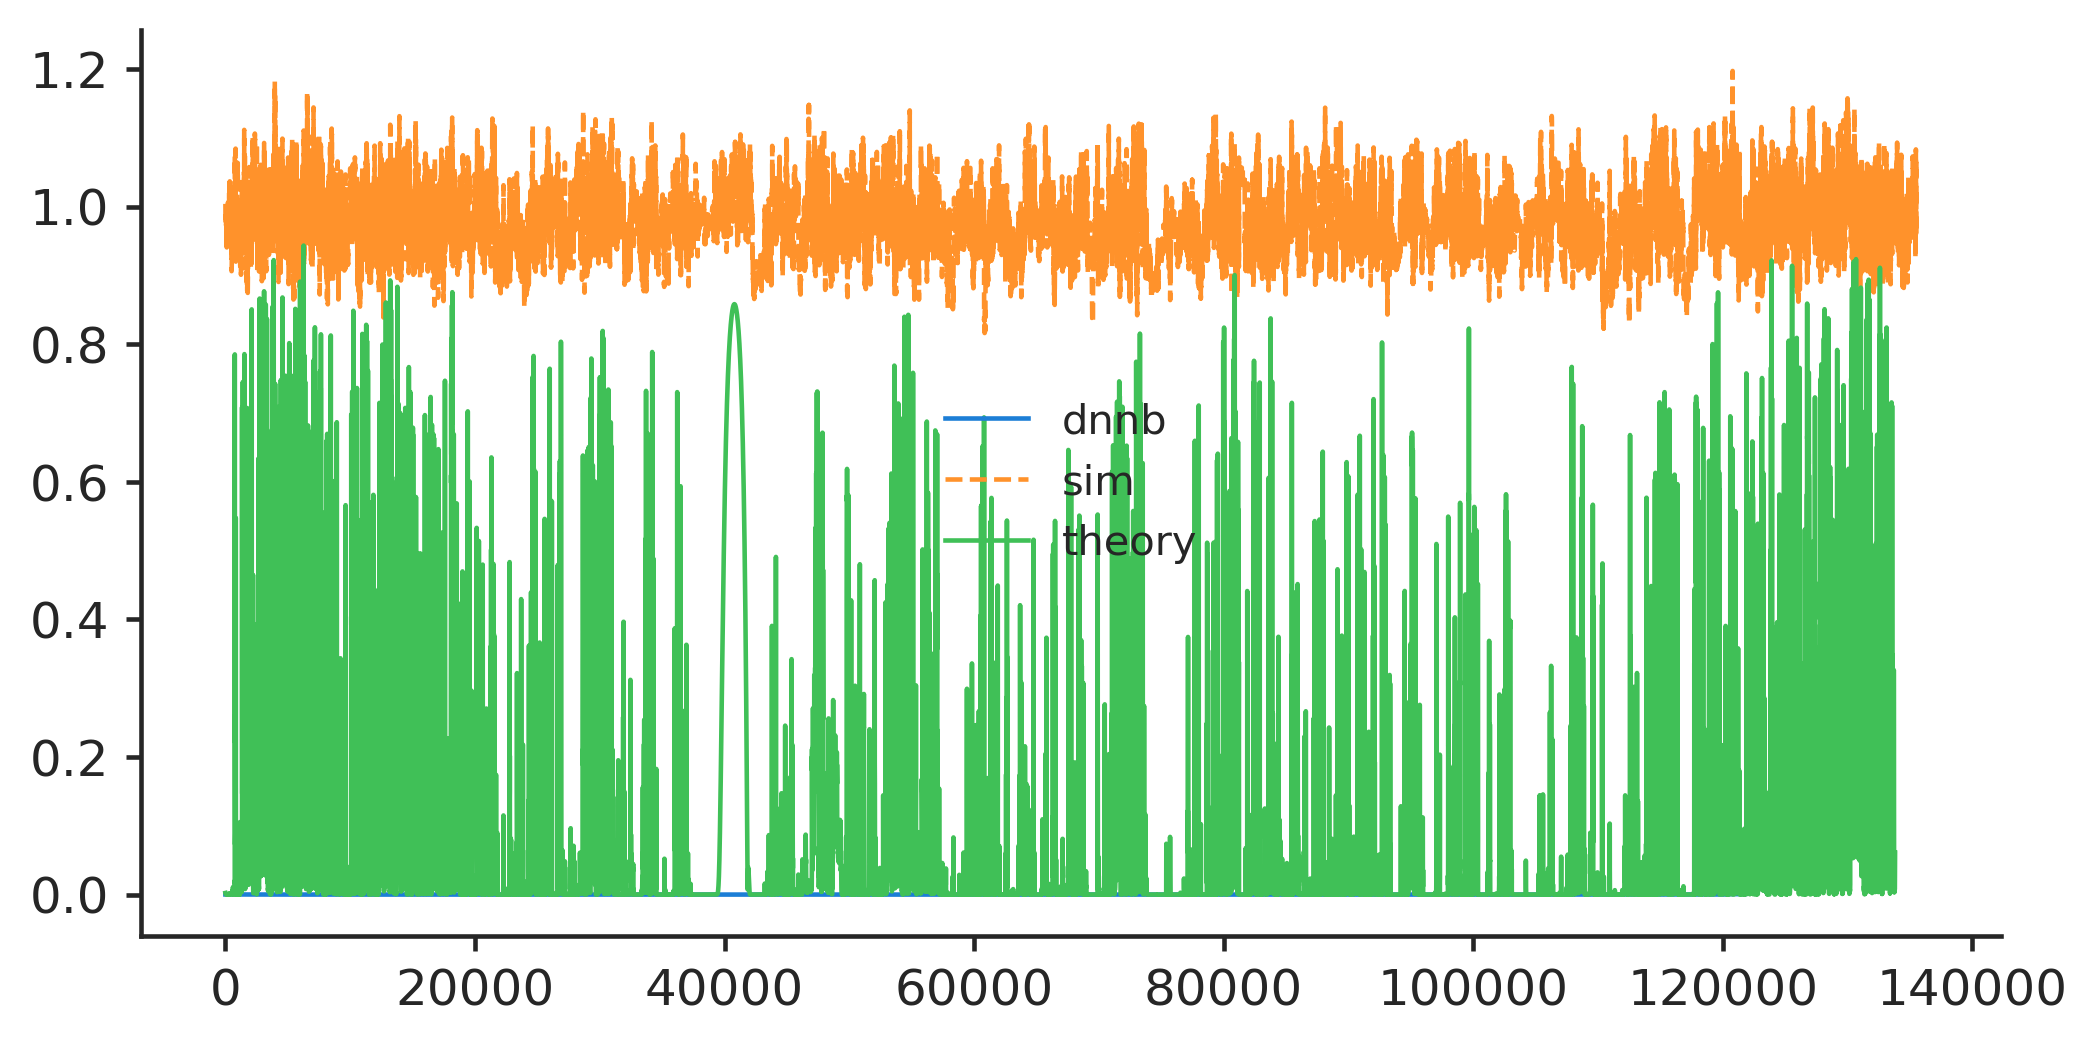

In [53]:
wi = 1

Bs = 10**(np.concatenate(chr10_bs, axis=2))

sels = range(len(info['t'])-1)
sels = [2]

for i in sels:
    s = info['t'][i]
    mu = info['w'][wi]
    res = sims.get((('s', 2*s), ('mu', mu)), None)

    pos_all, b_all = res
    bvar = b_all.var(axis=1)
    bmean = b_all.mean(axis=1)
    
    print(info['t'][i])#, m.t[i])
    print(info['w'][wi])#, m.w[wi])
    line = plt.plot(np.arange(0, Bs.shape[2]), Bs[wi, i, :], label='dnnb')
    plt.plot(bmean, linestyle='dashed', label='sim')
    plt.plot(10**m.Bs['chr10'][:, wi, i, 0], label='theory')
plt.legend()

0.0001
1e-08


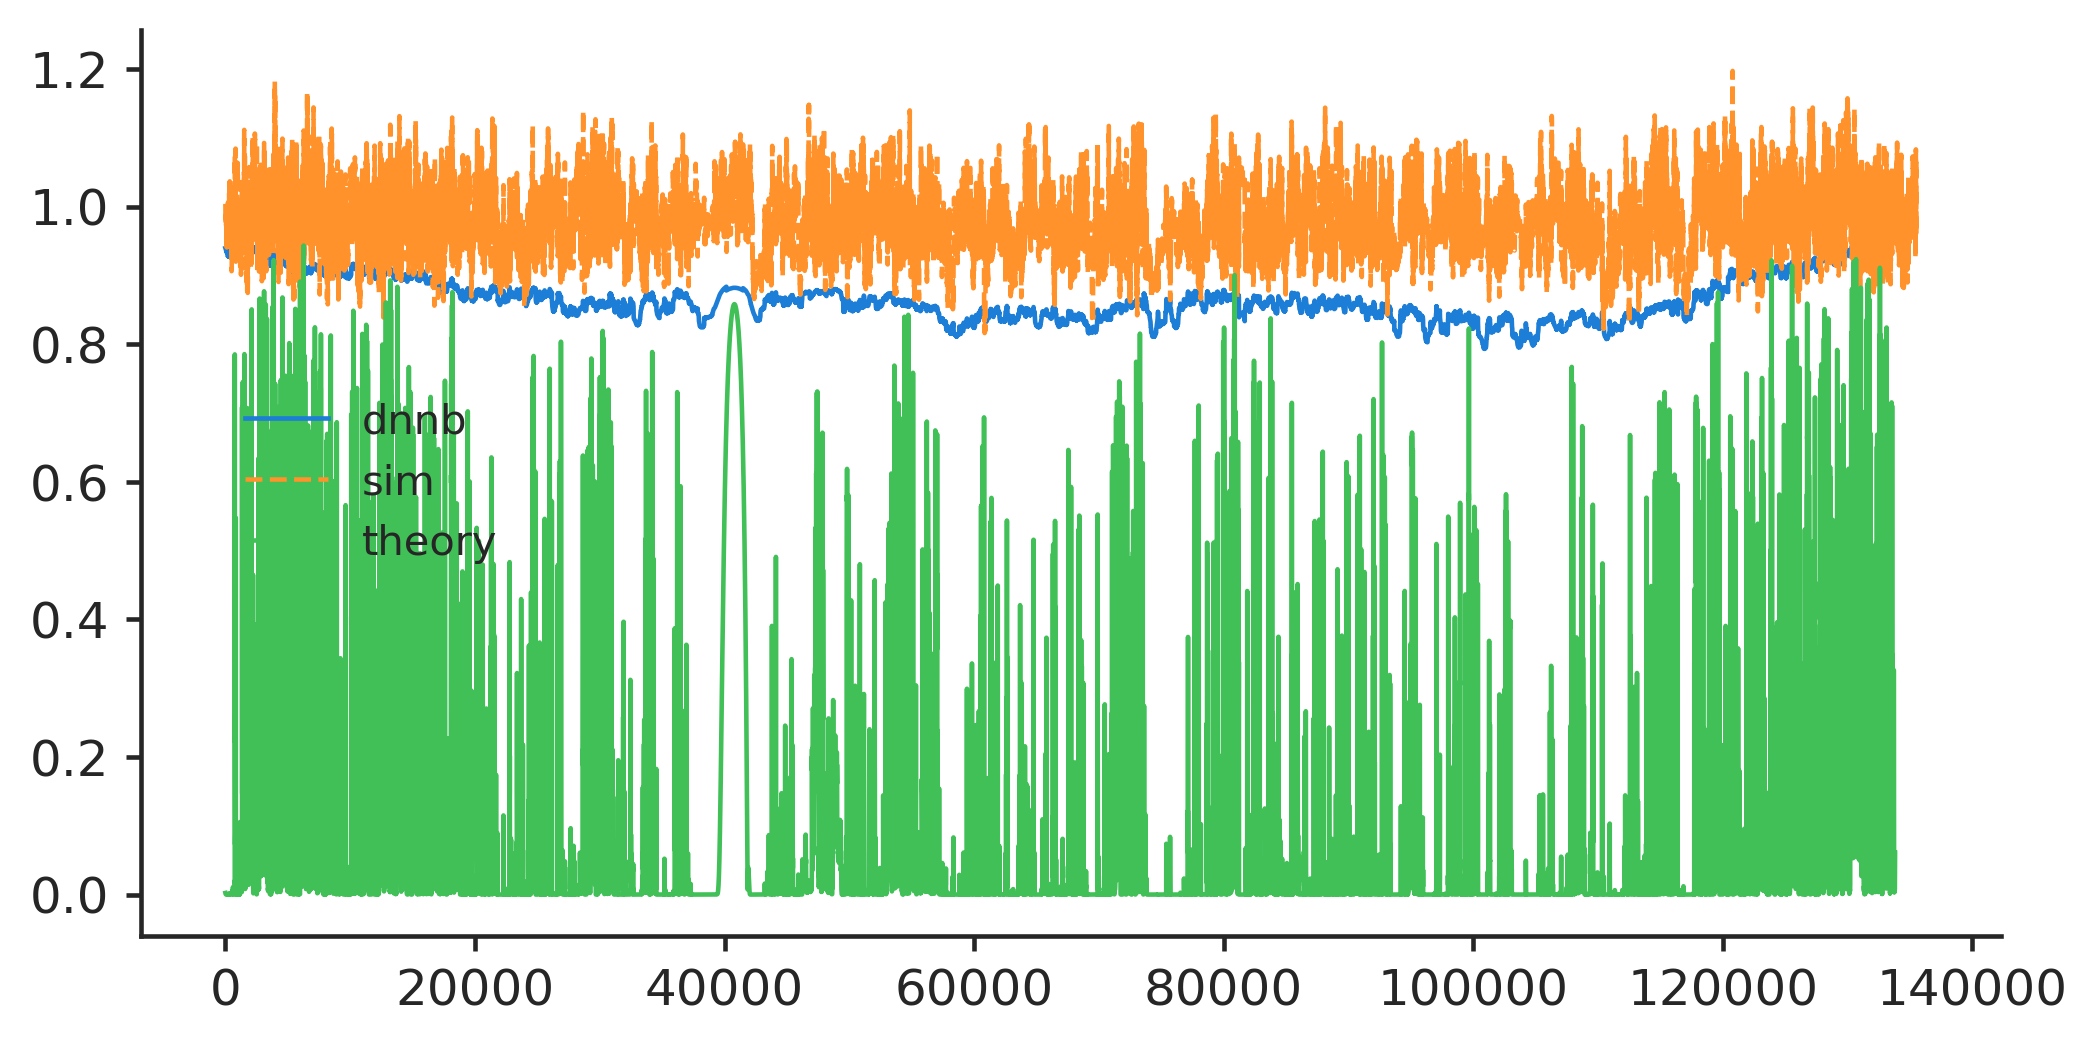

In [39]:
wi = 1

Bs = 10**(np.concatenate(chr10_bs, axis=2))

sels = range(len(info['t'])-1)
sels = [2]

for i in sels:
    s = info['t'][i]
    mu = info['w'][wi]
    res = sims.get((('s', 2*s), ('mu', mu)), None)

    pos_all, b_all = res
    bvar = b_all.var(axis=1)
    bmean = b_all.mean(axis=1)
    
    print(info['t'][i])#, m.t[i])
    print(info['w'][wi])#, m.w[wi])
    line = plt.plot(np.arange(0, Bs.shape[2]), Bs[wi, i, :], label='dnnb')
    plt.plot(bmean, linestyle='dashed', label='sim')
    plt.plot(10**m.Bs['chr10'][:, wi, i, 0], label='theory')
plt.legend()

1e-05
1e-08


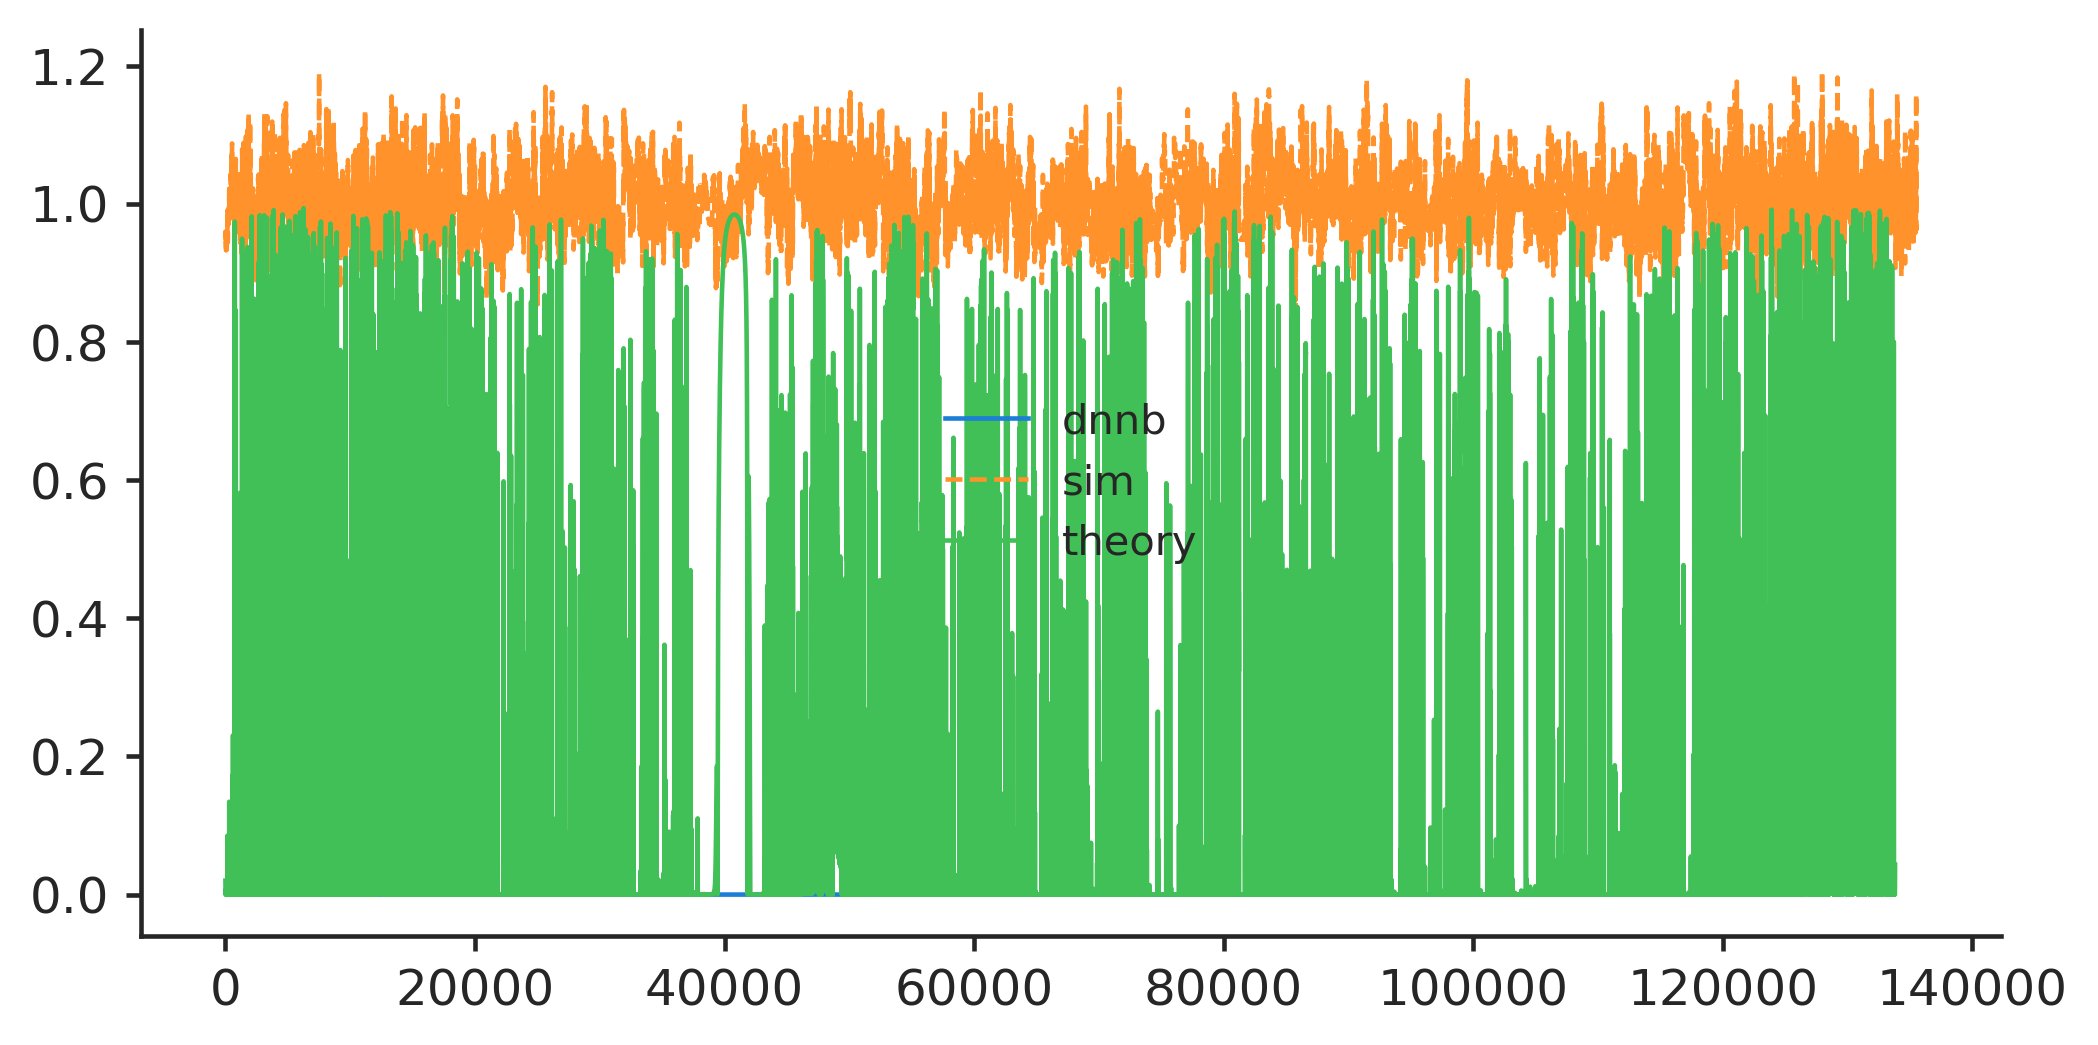

In [54]:
wi = 1

Bs = 10**(np.concatenate(chr10_bs, axis=2))

sels = range(len(info['t'])-1)
sels = [3]

for i in sels:
    s = info['t'][i]
    mu = info['w'][wi]
    res = sims.get((('s', 2*s), ('mu', mu)), None)

    pos_all, b_all = res
    bvar = b_all.var(axis=1)
    bmean = b_all.mean(axis=1)
    
    print(info['t'][i])#, m.t[i])
    print(info['w'][wi])#, m.w[wi])
    line = plt.plot(np.arange(0, Bs.shape[2]), Bs[wi, i, :], label='dnnb')
    plt.plot(bmean, linestyle='dashed', label='sim')
    plt.plot(10**m.Bs['chr10'][:, wi, i, 0], label='theory')
plt.legend()

In [32]:
info['t']

array([1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06])

In [ ]:
for i in range(7):
    for j in range(7):
        plt.plot(10**x[i, j, :], label=j)

In [ ]:
B = np.round(10**a, 3)a

In [ ]:
b[1].shape

In [ ]:
np.round(10**np.sum(np.log10(b[1]), axis=0), 3)

In [ ]:
c = np.load('../out.npz')
plt.plot(c['rf'])

In [ ]:
c['Sm']

In [ ]:
plt.plot([c['Sm'][i, 3]  for i in range(1, c['Sm'].shape[0], 10_000)],
         [np.prod(bgs_segment(1e-8, 0.1, 1000, 1e-8, c['Sm'][:i, 3])) for i in range(1, c['Sm'].shape[0], 10_000)])

In [ ]:
plt.plot(c['rf'], c['b'][:, 5, 6])
plt.scatter(np.abs(0.4 - c['Sm'][19748:72178, 2]), np.repeat(1, c['Sm'][19748:72178, 2].shape[0]), s=0.1, c='r')
plt.xlim(0, 0.01)

In [ ]:
c['rf'].shape, c['b'].shape

In [ ]:
plt.plot([np.exp(np.sum(np.log(c['b'][20000:i, 3, 2]))) for i in range(0, c['b'].shape[0], 100)])

In [ ]:
plt.plot(b[1][:, 5, 4])

In [ ]:
plt.plot(np.round(10**a[4, 5, :], 2))

In [ ]:
FIT_DIR = '../data/msprime_sims/fits/'

models = [f for f in os.listdir(FIT_DIR) if not f.startswith('varying')]
#models = ['segment_uniform_mu']
res = {m: load_learnedfuncs_in_dir(os.path.join(FIT_DIR, m)) for m in models}

res.keys()

Todo

- smaller arch input size
 - different loss
 - downloading to uniform on B 
 - train past stopping point to see if val

## Simple BGS model

First we look at the simple BGS model, which just includes the total fixed recombination fraction. This is the same as `bgs_rec()` in the `bprime.theory` module.

The model is:

$$B_\mathrm{rec} = \exp\left({\frac{-\mu L}{(t(1+(1-t)r_\mathrm{BP}/t)^2)}}\right)$$

where $t = sh$.

### Variable $\mu$ and $t$

In [ ]:
arch_loss_plot(res['simple'])

n2 = {2, 4} does well here — things work well if the number of neurons per layer is the input size. 

In [ ]:
ARCH = (0, 0, 0, 0, 2)

In [ ]:
b_learn_diagnostic_plot(res['simple'][ARCH][0], n={'mu': 100, 'sh': 100}, c='sh')

In [ ]:
res['simple'][ARCH][0].bfunc

In [ ]:
rate_density_plot(res['simple'][ARCH][0])

### Variable $\mu$, $t$, and $L$ — $\mu$ and $t$ Log-scaled, $L$ Linear

In [ ]:
ARCH = (0, 0, 0, 0, 2)

In [ ]:
res['simple_varL'][ARCH][0].func

In [ ]:
arch_loss_plot(res['simple_varL'])

In [ ]:
b_learn_diagnostic_plot(res['simple_varL'][ARCH][0], n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10}, c='L', add_theory=False)

### Variable $\mu$, $t$, and $L$ — $\mu$, $t$, and $L$ Log-scaled

In [ ]:
res['simple_varlogL'][ARCH][0].func

In [ ]:
arch_loss_plot(res['simple_varlogL'])

In [ ]:
b_learn_diagnostic_plot(res['simple_varlogL'][ARCH][0], n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10}, c='L', add_theory=False)

### Variable $\mu$, $t$, $L$, and $r_\mathrm{BP}$ — Everything Log-scaled

In [ ]:
res['simple_varlogL_varrbp'][ARCH][0].func

In [ ]:
arch_loss_plot(res['simple_varlogL_varrbp'])

In [ ]:
res['simple_varlogL_varrbp'][ARCH][1].func.features

In [ ]:
b_learn_diagnostic_plot(res['simple_varlogL_varrbp'][ARCH][1], n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

Note there is a lot of variability here between model fits!

## Varying Number of Samples

In [ ]:
models = [f for f in os.listdir(FIT_DIR) if f.startswith('varying_nsamples')]
res_nsamp = {m: load_learnedfuncs_in_dir(os.path.join(FIT_DIR, m)) for m in models}

res_nsamp.keys()

In [ ]:
nsamps, nreps, theory_maes, theory_mses = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
predict_mses, predict_maes = defaultdict(list), defaultdict(list)

def get_nsamps_nrps(model):
    match = re.match(r'varying_nsamples_(?P<nsamps>\d+)_(?P<nreps>\d+)', model)
    assert match is not None
    return tuple(map(int, match.groups()))

for name, archs in res_nsamp.items():
    nsamp, nrep = get_nsamps_nrps(name)
    for arch in archs.keys():
        for func in archs[arch]:
            nsamps[arch].append(nsamp)
            nreps[arch].append(nrep)
            theory_maes[arch].append(func.theory_loss(loss='mae'))            
            theory_mses[arch].append(func.theory_loss(loss='mse'))
            predict_maes[arch].append(func.predict_loss(loss='mae'))
            predict_mses[arch].append(func.predict_loss(loss='mse'))            

In [ ]:
ARCH = (0, 0, 0, 0, 2)
df = pd.DataFrame(dict(nsamps=nsamps[ARCH], nreps=nreps[ARCH], theory_mae=theory_maes[ARCH], predict_mae=predict_maes[ARCH]))

fig, ax = plt.subplots()

for nrep, dfg in df.groupby('nreps'):
    x, y = dfg['nsamps'].values * nrep, dfg['theory_mae'].values
    idx = np.argsort(x)
    ax.scatter(x[idx], y[idx], label=nrep)
    means = defaultdict(list)
    for xx, yy in zip(x, y):
        means[xx].append(yy)
    agg_x = np.array(list(means.keys()))
    agg_y = np.array([np.mean(v) for v in means.values()])
    idx = np.argsort(agg_x)
    ax.plot(agg_x[idx], agg_y[idx])
ax.legend(loc='upper right', ncol=2)
semilog = False
if semilog:
    ax.semilogx()
else:
    ax.loglog()
ax.legend()
ax.set_ylabel("theory loss")
ax.set_xlabel("number of samples x number replicates")
ax.grid(which='both')

In [ ]:
ARCH = (0, 0, 0, 0, 4)
df = pd.DataFrame(dict(nsamps=nsamps[ARCH], nreps=nreps[ARCH], theory_mae=theory_maes[ARCH], predict_mae=predict_maes[ARCH]))

fig, ax = plt.subplots()

for nrep, dfg in df.groupby('nreps'):
    x, y = dfg['nsamps'].values * nrep, dfg['theory_mae'].values
    idx = np.argsort(x)
    ax.scatter(x[idx], y[idx], label=nrep)
    means = defaultdict(list)
    for xx, yy in zip(x, y):
        means[xx].append(yy)
    agg_x = np.array(list(means.keys()))
    agg_y = np.array([np.mean(v) for v in means.values()])
    idx = np.argsort(agg_x)
    ax.plot(agg_x[idx], agg_y[idx])
ax.legend(loc='upper right', ncol=2)
semilog = False
if semilog:
    ax.semilogx()
else:
    ax.loglog()
ax.legend()
ax.set_ylabel("theory loss")
ax.set_xlabel("number of samples x number replicates")
ax.grid(which='both')

In [ ]:
ARCH = (0, 0, 0, 0, 4)
df = pd.DataFrame(dict(nsamps=nsamps[ARCH], nreps=nreps[ARCH], theory_mae=theory_maes[ARCH], predict_mae=predict_maes[ARCH]))

fig, ax = plt.subplots()
for nrep, dfg in df.groupby('nreps'):
    x, y = dfg['nsamps'].values, dfg['theory_mae'].values
    idx = np.argsort(x)
    ax.scatter(x[idx], y[idx], label=nrep)
    means = defaultdict(list)
    for xx, yy in zip(x, y):
        means[xx].append(yy)
    agg_x = np.array(list(means.keys()))
    agg_y = np.array([np.mean(v) for v in means.values()])
    idx = np.argsort(agg_x)
    ax.plot(agg_x[idx], agg_y[idx])
ax.legend(loc='upper right', ncol=2)
semilog = False
if semilog:
    ax.semilogx()
else:
    ax.loglog()
ax.legend()
ax.set_ylabel("theory loss")
ax.set_xlabel("number of samples")
ax.grid(which='both')

In [ ]:
ARCH = (0, 0, 4, 2, 0)
df = pd.DataFrame(dict(nsamps=nsamps[ARCH], nreps=nreps[ARCH], theory_mae=theory_maes[ARCH], predict_mae=predict_maes[ARCH]))

fig, ax = plt.subplots()

for nrep, dfg in df.groupby('nreps'):
    x, y = dfg['nsamps'].values.astype(int), dfg['predict_mae'].values
    idx = np.argsort(x)
    ax.scatter(x[idx], y[idx], label=nrep)
    means = defaultdict(list)
    for xx, yy in zip(x, y):
        means[xx].append(yy)
    agg_x = np.array(list(means.keys()))
    agg_y = np.array([np.mean(v) for v in means.values()])
    idx = np.argsort(agg_x)
    ax.plot(agg_x[idx], agg_y[idx])
ax.legend(loc='upper right', ncol=2)
ax.semilogx()
ax.legend()

In [ ]:
res_nsamp['varying_nsamples_1000000_10'].keys()

In [ ]:
ARCH = (0, 0, 0, 0, 4)

In [ ]:
def nvary_title(nsamps, nreps):
    return f"nsamps = {ns:,}, nreps={nr:,}, total={ns*nr/1e6:,}M"

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

ns, nr = 100_000, 5
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][1]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax1))


ns, nr = 1_000_000, 2
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][0]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax2))


In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

ns, nr = 2_000_000, 1
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][1]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax1))


ns, nr = 1_000_000, 2
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][0]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax2))


In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

ns, nr = 2_000_000, 1
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][1]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax1))
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][0]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax1))

ns, nr = 1_000_000, 2
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][1]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax2))
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][0]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax2))

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

# thin params
ns, nr = 2_000_000, 1
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][1]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax1))

ns, nr = 1_000_000, 2
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][0]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax2))


In [ ]:
rate_density_plot(bfunc)

### Tables of Theory MAE

#### Unaveraged

In [ ]:
# wide params
df['total'] = df['nsamps'] * df['nreps'] / 1e6
df.sort_values('theory_mae').loc[lambda x: x.total <= 5].sort_values('theory_mae').head(10)

In [ ]:
# narrow params
df['total'] = df['nsamps'] * df['nreps'] / 1e6
df.sort_values('theory_mae').loc[lambda x: x.total <= 5].sort_values('theory_mae').head(10)

#### Averaged

Interpret with caution; only two things are being averaged here...

In [ ]:
# wide
df.groupby(['nsamps', 'nreps', 'total'])['theory_mae', 'predict_mae'].mean().reset_index().loc[lambda x: x.total <= 5].sort_values('theory_mae').head(20)

In [ ]:
# thin
df.groupby(['nsamps', 'nreps', 'total'])['theory_mae', 'predict_mae'].mean().reset_index().loc[lambda x: x.total <= 5].sort_values('theory_mae').head(20)

How does varying number of samples/replicates impact bias

In [ ]:
nsamps, nreps = 1_000_000, 5

figax = None
for i in range(2):
    bf = res_nsamp[f'varying_nsamples_{nsamps}_{nreps}'][ARCH][i]
    figax = feature_loss_plots(bf, 50, loss='mse', figax=figax)

In [ ]:
nsamps, nreps = 1_000_000, 5

figax = None
for i in range(2):
    bf = res_nsamp[f'varying_nsamples_{nsamps}_{nreps}'][ARCH][i]
    figax = feature_loss_plots(bf, 50, loss='bias', figax=figax)

## Segment BGS Model

$$B_\mathrm{seg} = \exp\left(\int_0^L \frac{dl}{t(1+(1-t)(c + r_\text{BP}l)/t)^2}\right) = \exp\left(\frac{r_\text{BP} L t}{(c  (1-t)+t) ((1-t) r_\text{BP} L +t + c (1 - t))} \right)$$

where $c$ is the recombination fraction between the focal neutral site and the start of the segment with length $L$.

### With Everything on a Log-scale

Slightly reduced paramter space — `rf` goes only to $10^{-3}$.

In [ ]:
bgs_segment(1e-8, 1e-1, 1000, 1e-8, 1e-4)

In [ ]:
res['segment_logL_logrbp_logrf'][ARCH][0].func

In [ ]:
arch_loss_plot(res['segment_logL_logrbp_logrf'])

In [ ]:
ARCH = (0, 0, 0, 0, 2)

b_learn_diagnostic_plot(res['segment_logL_logrbp_logrf'][ARCH][0], n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

Some little experiments to get a sense of scales, etc.

In [ ]:
rf = 10**np.linspace(-10, np.log10(0.5), 100)
plt.plot(rf, bgs_segment(1e-8, 1e-2, 1000, 1e-8, rf))
plt.plot(rf, bgs_segment(1e-7, 1e-2, 1000, 1e-8, rf))
plt.plot(rf, bgs_segment(1e-7, 1e-3, 1000, 1e-8, rf))

plt.axhline(1)
plt.semilogx()

In [ ]:
res['segment_logL_logrbp_logrf'][ARCH][0].func

## TODO

In [ ]:
# Note that the training data does not log10 mu, but here we do (otherwise the grid looks
# like chunky peanut butter).
bs = []
ys = []
func = res['segment_logL_logrbp_logrf'][ARCH][0].func
for sh in np.logspace(-5, -1,  20):
    (mu_grid_rbp, s_grid_rbp, a, b, c), X_mesh_orig_rbp, X_mesh_rbp, predict_grid_rbp = func.predict_grid({'rf': 100},
                                                                            fix_X={'mu': 1e-5, 
                                                                                   'sh': np.log10(sh),
                                                                                   'rbp': 1e-8,
                                                                                    'L': 1_000})
    bs.append(a)
    ys.append(predict_grid_rbp)


In [ ]:
func.predict_grid({'rf': 100},fix_X={'mu': 1e-5, 'sh': np.log10(sh),'rbp': 1e-8,'L': 1_000})

In [ ]:
cmap = cm.viridis(np.linspace(0, 1, 20))
for i, y in enumerate(ys):
    plt.plot(np.log10(bs[0]), y.squeeze(), c=cmap[i])

In [ ]:
rate_density_plot(res['segment_logL_logrbp_logrf'][ARCH][0])

### Wide Parameter Range — Log Scale Parameters

In [ ]:
ARCH = (0, 0, 0, 0, 2)

In [ ]:
arch_loss_plot(res['segment_logL_logrbp_logrf_wide'])

In [ ]:
res['segment_logL_logrbp_logrf_wide'][ARCH][0].func.test_mae()

In [ ]:
res['segment_logL_logrbp_logrf_wide'][ARCH][0].theory_loss()

In [ ]:
res['segment_logL_logrbp_logrf_wide'][ARCH][0].func.X_test_raw

In [ ]:
theory_loss_plot(res['segment_logL_logrbp_logrf_wide'][ARCH][0])

In [ ]:
ARCH = (0, 0, 0, 0, 2)
b_learn_diagnostic_plot(res['segment_logL_logrbp_logrf_wide'][ARCH][0], 
                        n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

In [ ]:
ARCH = (0, 0, 0, 0, 2)
b_learn_diagnostic_plot(res['segment_logL_logrbp_logrf_wide'][ARCH][1], 
                        n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

In [ ]:
def ensemble(bfuncs, X):
    predicts = []
    assert len(set([tuple(bf.func.features) for bf in bfuncs])) == 1, "mismatching feature!"
    for bf in bfuncs:
        predicts.append(bf.func.predict(X))
    return np.array(predicts).squeeze().mean(axis=0)

Xt = res['segment_logL_logrbp_logrf_wide'][ARCH][0].func.X_test_raw
Xt

In [ ]:
a = ensemble(res['segment_logL_logrbp_logrf_wide'][ARCH], Xt)

In [ ]:
b = res['segment_logL_logrbp_logrf_wide'][ARCH][0].theory_B(Xt)

In [ ]:
plt.scatter(b, a, alpha=0.1, s=2)
plt.axline((0, 0), slope=1, c='r', linestyle='dashed')
print(np.mean(np.abs(a-b)))

In [ ]:
theory_loss_plot(res['segment_logL_logrbp_logrf_wide'][ARCH][0])

In [ ]:
figax = None
for i in range(2):
    figax = feature_loss_plots(res['segment_logL_logrbp_logrf_wide'][ARCH][i], 50, loss='bias', figax=figax)

In [ ]:
figax = None
for i in range(2):
    figax = feature_loss_plots(res['segment_logL_logrbp_logrf_wide'][ARCH][i], 50, loss='mae', figax=figax)

### Rejection Sampling Test

#### Unreplicated Rejection Sampling

In [ ]:
arch_loss_plot(res['segment_logL_logrbp_logrf_wide_reject'])

Interestingly, target rejection sampling (so the target's theoretic B is Uniform, based on theory — this won't be possible to know with the weak selection BGS) does lower loess, but doesn't seem to help out with theory MAE (I've looked at both reps; they're similar):

In [ ]:
ARCH = (0, 0, 0, 0, 2)
b_learn_diagnostic_plot(res['segment_logL_logrbp_logrf_wide_reject'][ARCH][1], 
                        n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

In [ ]:
ARCH = (0, 0, 0, 0, 2)
b_learn_diagnostic_plot(res['segment_logL_logrbp_logrf_wide_reject'][ARCH][0], 
                        n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

In [ ]:
reject_mae = [res['segment_logL_logrbp_logrf_wide_reject'][ARCH][0].theory_loss(),
              res['segment_logL_logrbp_logrf_wide_reject'][ARCH][1].theory_loss()]
standard_mae = [res['segment_logL_logrbp_logrf_wide'][ARCH][0].theory_loss(),
              res['segment_logL_logrbp_logrf_wide'][ARCH][1].theory_loss()]
                            

In [ ]:
np.mean(reject_mae), np.mean(standard_mae)

Check the empirical B distribution — indeed it's flat between 0 and 1:

In [ ]:
_ = plt.hist(res['segment_logL_logrbp_logrf_wide_reject'][ARCH][0].theory_B(), 80)

In [ ]:
Xcols = res['segment_logL_logrbp_logrf_wide_reject'][ARCH][0].func.col_indexer()
_ = plt.hist(np.log10(res['segment_logL_logrbp_logrf_wide_reject'][ARCH][0].func.X_test_orig_linear[:, Xcols('mu')]/res['segment_logL_logrbp_logrf_wide_reject'][ARCH][0].func.X_test_orig_linear[:, Xcols('sh')]), 80)

Interestingly, the bias is flatter now:

In [ ]:
figax = None
for i in range(2):
    figax = feature_loss_plots(res['segment_logL_logrbp_logrf_wide_reject'][ARCH][i], 50, loss='bias', figax=figax)

In [ ]:
figax = None
for i in range(2):
    figax = feature_loss_plots(res['segment_logL_logrbp_logrf_wide_reject'][ARCH][i], 50, loss='mae', figax=figax)

#### Replicated Rejection Sampling

In [ ]:
ARCH = (0, 0, 0, 0, 2)
b_learn_diagnostic_plot(res['segment_logL_logrbp_logrf_wide_reject_replicated'][ARCH][0], 
                        n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

In [ ]:
figax = None
for i in range(2):
    bf = res['segment_logL_logrbp_logrf_wide_reject_replicated'][ARCH][1]
    figax = feature_loss_plots(bf, 50, loss='bias', figax=figax)

## Time Estimation

In [ ]:
def time_estimation(total_sims, ncores=1, sec_per_sim = 10):
    min_per_sec = 1/60
    hour_per_min = 1/60
    day_per_hour = 1/24
    return total_sims * sec_per_sim * min_per_sec * hour_per_min * day_per_hour 

def time(total_sims, ncores):
    time = time_estimation(total_sims)
    print(f"{np.round(total_sims/1e6, 2)}M sims total will take ~{np.round(time/ncores, 2)} days, across {ncores} cores")

time(5e6, 500)
time(5e6, 70)
time(5e6, 1)